# Set up

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-03-01 12:13:34.058537: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 12:13:34.087014: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-01 12:13:34.184057: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 12:13:34.184128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 12:13:34.199985: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Vanishing/Exploding Gradients Problem

In [16]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

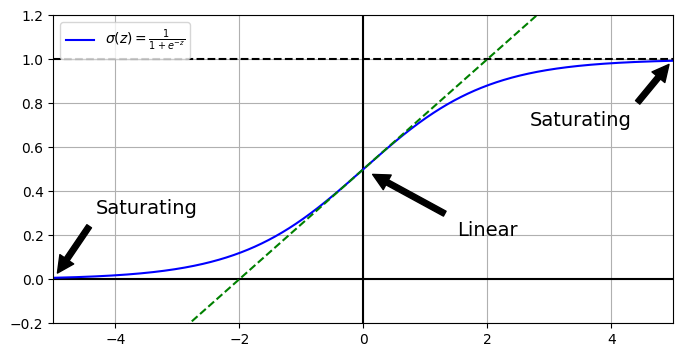

In [17]:
z = np.linspace(-5, 5, 1000)

plt.figure(figsize=(8, 4))
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, 1.2], "k-")
plt.plot(z, sigmoid(z), "b-", label=r"$\sigma(z) = \frac{1}{1 + e^{-z}}$")
plt.plot([-5, 5], [-3 / 4, 7 / 4], "g--")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Saturating",
    xytext=(3.5, 0.7),
    xy=(5, 1),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Saturating",
    xytext=(-3.5, 0.3),
    xy=(-5, 0),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Linear", xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center"
)
plt.grid()
plt.legend(loc="upper left")
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Xavier and He initialization                

You can switch to your desired initialization by setting the `kernel_initializer` hyperparameter.

In [18]:
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

If you want to use He initialization with a uniform distribution and based on $fan_{avg}$ instead of $fan_{in}$, you can use the `VarianceScaling` initializer.

In [19]:
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2.0, mode="fan_avg", distribution="uniform"
)
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)

## Non-saturating Activation Functions

### Leaky ReLU

In [20]:
def leaky_relu(z, alpha):
    return np.maximum(z, alpha * z)

(-5.0, 5.0, -1.0, 4.0)

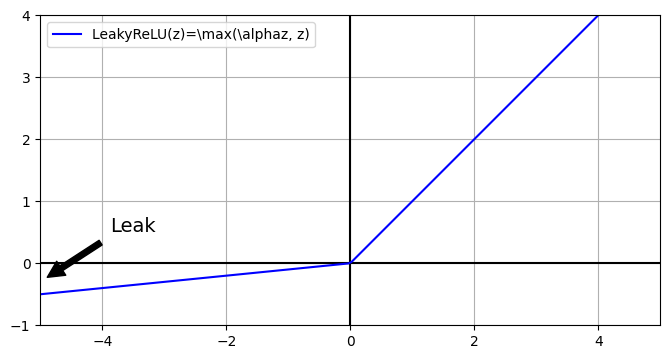

In [21]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=((8, 5)))
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot(z, leaky_relu(z, 0.1), "b-", label=r"LeakyReLU(z)=\max(\alphaz, z)")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Leak",
    xy=(-5, -0.3),
    xytext=(-3.5, 0.5),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.gca().set_aspect("equal")
plt.grid()
plt.legend()
plt.axis([-5, 5, -1, 4])

In [22]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu, kernel_initializer="he_normal")

In [23]:
model = tf.keras.Sequential(
    [
        # some layers
        tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
        tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
        # more layers
    ]
)

### ELU and SELU

- We reimplement the SELU using the coefficient in the paper. <br>
- Note that `erfc(x)` function stands for Complementary Error Function, which is defined as `1-rfc(x)`, where `erf(x)` is the Error Function.<br>
- The formula of `erf()` is:
$$\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}$$
- `erfc(x)` is related to the cumulative distribution function (CDF) of a standard normal distribution:
$$erfc\left(\frac{x}{\sqrt{2}}\right)=2 \times CDF(-x) $$

In [24]:
from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e**2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    )
    ** (-1 / 2)
)


def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)


def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

In [25]:
scale_0_1

1.0507009873554805

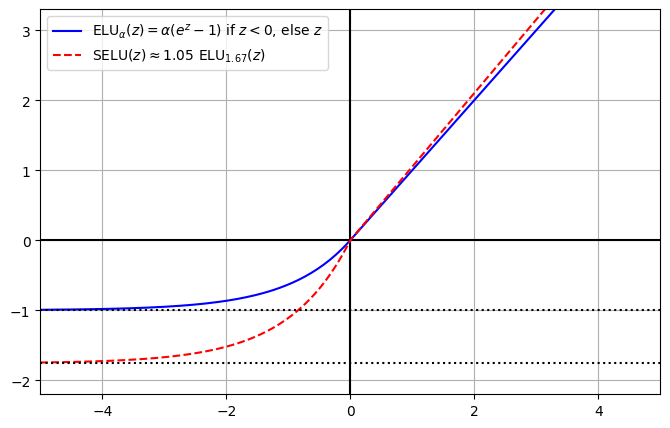

In [26]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(8, 5))
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot(z, elu(z), "b-", label=r"ELU$_\alpha(z)=\alpha(e^z-1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", label=r"SELU$(z)\approx1.05 \ $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [-1, -1], "k:")
plt.plot([-5, 5], [-scale_0_1 * alpha_0_1, -scale_0_1 * alpha_0_1], "k:")
plt.legend()
plt.grid()
plt.axis([-5, 5, -2.2, 3.3])
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization.

In [27]:
dense = tf.keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal")

Similarly, using SELU is straightforward.

In [28]:
dense = tf.keras.layers.Dense(50, activation="selu", kernel_initializer="lecun_normal")

**Extra material - an example of a self-regularized network using SELU**

Here we create a neural network for Fashion MNIST with 100 hidden layers, using the SELU activation function.

In [29]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [30]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

Now let's train it. Do not forget to scale the input to mean 0 and standard deviation 1.

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

In [4]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [5]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [29]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 22s 13ms/step - loss: 1.0991 - accuracy: 0.5797 - val_loss: 0.8067 - val_accuracy: 0.7004
Epoch 2/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.8209 - accuracy: 0.6829 - val_loss: 0.6667 - val_accuracy: 0.7444
Epoch 3/5
1719/1719 [==============================] - 23s 14ms/step - loss: 0.7469 - accuracy: 0.7032 - val_loss: 0.6544 - val_accuracy: 0.7542
Epoch 4/5
1719/1719 [==============================] - 23s 14ms/step - loss: 0.7435 - accuracy: 0.7183 - val_loss: 0.6809 - val_accuracy: 0.7442
Epoch 5/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.6835 - accuracy: 0.7459 - val_loss: 0.9000 - val_accuracy: 0.6490


The network managed to learn, despite how deep it is. Now look at what happened if we try to use the ReLU activation function instead.

In [32]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [33]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

In [34]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 25s 12ms/step - loss: 1.8603 - accuracy: 0.2249 - val_loss: 1.3798 - val_accuracy: 0.4432
Epoch 2/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.2928 - accuracy: 0.4329 - val_loss: 0.9994 - val_accuracy: 0.5960
Epoch 3/5
1719/1719 [==============================] - 20s 12ms/step - loss: 1.1652 - accuracy: 0.5086 - val_loss: 1.0402 - val_accuracy: 0.5484
Epoch 4/5
1719/1719 [==============================] - 20s 12ms/step - loss: 0.9442 - accuracy: 0.6001 - val_loss: 0.8474 - val_accuracy: 0.6672
Epoch 5/5
1719/1719 [==============================] - 20s 12ms/step - loss: 0.8206 - accuracy: 0.6624 - val_loss: 0.8358 - val_accuracy: 0.6390


Not so great, we suffer from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

In [3]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)


def approx_gelu(z):
    return swish(z, beta=1.702)


def softplus(z):
    return np.log(np.exp(z) + 1)


def mish(z):
    return z * np.tanh(softplus(z))

Text(0.5, 0, 'z')

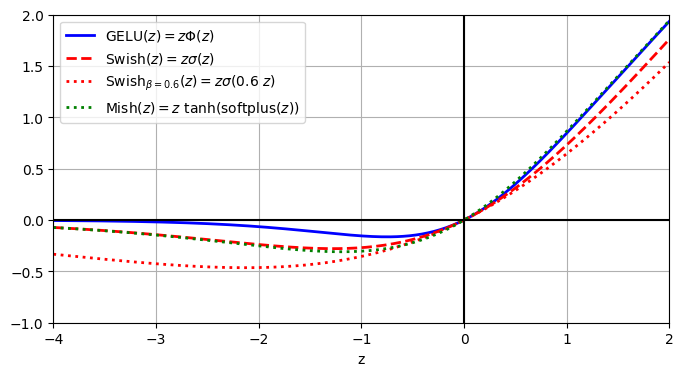

In [26]:
z = np.linspace(-4, 2, 200)

beta = 0.6
plt.figure(figsize=(8, 4))
plt.plot(z, approx_gelu(z), "b-", linewidth=2, label=r"GELU$(z)=z\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2, label=r"Swish$(z)=z\sigma(z)$")
plt.plot(
    z,
    swish(z, 0.6),
    "r:",
    linewidth=2,
    label=rf"Swish$_{{\beta={beta}}}(z)=z\sigma({beta} \ z)$",
)
plt.plot(z, mish(z), "g:", linewidth=2, label=r"Mish$(z)=z \ \tanh($softplus$(z))$")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-5, 5], "k-")
plt.legend()
plt.grid()
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("z")

# Batch Normalization

In [14]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [16]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In this tiny example, just two hidden layers batch normalization is unlikely to make a huge impact, but ofr deeper network it can have a tremendous difference.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

Let's look at the parameters of the first BN layer:

In [19]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [22]:
# Extra code - just to verify that the model works
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5594 - accuracy: 0.8046 - val_loss: 0.3973 - val_accuracy: 0.8566
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4073 - accuracy: 0.8540 - val_loss: 0.3621 - val_accuracy: 0.8682


In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [28]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [30]:
# Extra code - just to verify that the model works
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)
model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

1719/1719 [==============================] - 4s 2ms/step - loss: 0.6181 - accuracy: 0.7930 - val_loss: 0.4408 - val_accuracy: 0.8428


## Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` argument.

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Transfer Learning with Keras

In [57]:
sandal_idx = class_names.index("Pullover")
shirt_idx = class_names.index("T-shirt/top")


def split_dataset(X, y):
    # Here, as the model B contains only 2 classes, we assume the positive class is the sandal class and the negative class is the shirt class
    y_for_B = (y == sandal_idx) | (y == shirt_idx)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == sandal_idx).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([sandal_idx, shirt_idx]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return (X[~y_for_B], y_A), (X[y_for_B], y_B)


(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [58]:
tf.random.set_seed(42)
model_A = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="softmax"),
    ]
)
model_A.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)
history = model.fit(
    X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A)
)
model_A.save("my_model_A")

Epoch 1/20


1376/1376 [==============================] - 16s 11ms/step - loss: 0.2536 - accuracy: 0.9164 - val_loss: 0.2706 - val_accuracy: 0.9158
Epoch 2/20
1376/1376 [==============================] - 15s 11ms/step - loss: 0.2321 - accuracy: 0.9226 - val_loss: 0.3330 - val_accuracy: 0.8797
Epoch 3/20
1376/1376 [==============================] - 15s 11ms/step - loss: 0.2252 - accuracy: 0.9254 - val_loss: 0.2488 - val_accuracy: 0.9193
Epoch 4/20
1376/1376 [==============================] - 15s 11ms/step - loss: 0.2208 - accuracy: 0.9246 - val_loss: 0.3057 - val_accuracy: 0.8962
Epoch 5/20
1376/1376 [==============================] - 15s 11ms/step - loss: 0.2331 - accuracy: 0.9225 - val_loss: 0.2716 - val_accuracy: 0.9105
Epoch 6/20
1376/1376 [==============================] - 14s 10ms/step - loss: 0.2114 - accuracy: 0.9301 - val_loss: 0.2842 - val_accuracy: 0.9070
Epoch 7/20
1376/1376 [==============================] - 14s 10ms/step - loss: 0.2045 - accuracy: 0.9317 - val_loss: 0.2532 - val_accura

INFO:tensorflow:Assets written to: my_model_A/assets


In [59]:
tf.random.set_seed(42)
model_B = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model_B.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)
history = model_B.fit(
    X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B)
)
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 28ms/step - loss: 0.7941 - accuracy: 0.4450 - val_loss: 0.7344 - val_accuracy: 0.4896
Epoch 2/20
7/7 [==============================] - 0s 10ms/step - loss: 0.7461 - accuracy: 0.4450 - val_loss: 0.6975 - val_accuracy: 0.4965
Epoch 3/20
7/7 [==============================] - 0s 10ms/step - loss: 0.7069 - accuracy: 0.4600 - val_loss: 0.6641 - val_accuracy: 0.5579
Epoch 4/20
7/7 [==============================] - 0s 9ms/step - loss: 0.6701 - accuracy: 0.5500 - val_loss: 0.6402 - val_accuracy: 0.6835
Epoch 5/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6443 - accuracy: 0.6850 - val_loss: 0.6185 - val_accuracy: 0.7873
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 0.6208 - accuracy: 0.7800 - val_loss: 0.5990 - val_accuracy: 0.8368
Epoch 7/20
7/7 [==============================] - 0s 9ms/step - loss: 0.5992 - accuracy: 0.8250 - val_loss: 0.5819 - val_accuracy: 0.8576
Epoch 8/20
7/7 [===============

[0.4348674416542053, 0.9380000233650208]

Model B reached 93.80% accuracy on the test set. Now let's try reusing the pretrained model A.

In [60]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so if we train one, it will update both models. If we want to avoid this, we need to build `model_B_on_A` on top of a *clone* of `model_A`.

In [61]:
tf.random.set_seed(42)

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [62]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [63]:
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B)
)

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B)
)

Epoch 1/4
7/7 [==============================] - 0s 23ms/step - loss: 0.8287 - accuracy: 0.1550 - val_loss: 0.8025 - val_accuracy: 0.2364
Epoch 2/4
7/7 [==============================] - 0s 9ms/step - loss: 0.8264 - accuracy: 0.1650 - val_loss: 0.8006 - val_accuracy: 0.2354
Epoch 3/4
7/7 [==============================] - 0s 10ms/step - loss: 0.8239 - accuracy: 0.1650 - val_loss: 0.7986 - val_accuracy: 0.2453
Epoch 4/4
7/7 [==============================] - 0s 9ms/step - loss: 0.8206 - accuracy: 0.1700 - val_loss: 0.7968 - val_accuracy: 0.2483
Epoch 1/16
7/7 [==============================] - 0s 24ms/step - loss: 0.8037 - accuracy: 0.2000 - val_loss: 0.7620 - val_accuracy: 0.3333
Epoch 2/16
7/7 [==============================] - 0s 11ms/step - loss: 0.7668 - accuracy: 0.2950 - val_loss: 0.7315 - val_accuracy: 0.4233
Epoch 3/16
7/7 [==============================] - 0s 11ms/step - loss: 0.7332 - accuracy: 0.4150 - val_loss: 0.7045 - val_accuracy: 0.4965
Epoch 4/16
7/7 [=================

So what's the final verdict?

In [64]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.4754 - accuracy: 0.9065


[0.47539809346199036, 0.906499981880188]

Well, to our surprise, the model's performance actually drops! The full explanation is in the note.md. 

# Faster Optimizers

In [20]:
# Build some help function to test an optimizer on Fashion MNIST


def build_model(seed: int = 42):
    tf.random.set_seed(42)
    return tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=[28, 28]),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(100, activation="softmax"),
        ]
    )


def build_and_train_model(
    optimizer: tf.keras.optimizers.Optimizer,
) -> tf.keras.callbacks.History:
    model = build_model()
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )
    return model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

In [7]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [8]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8005 - accuracy: 0.7338 - val_loss: 0.5202 - val_accuracy: 0.8174
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4913 - accuracy: 0.8289 - val_loss: 0.4657 - val_accuracy: 0.8346
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4383 - accuracy: 0.8463 - val_loss: 0.4298 - val_accuracy: 0.8492
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4094 - accuracy: 0.8573 - val_loss: 0.3955 - val_accuracy: 0.8606
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3866 - accuracy: 0.8642 - val_loss: 0.3790 - val_accuracy: 0.8638
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3706 - accuracy: 0.8681 - val_loss: 0.3766 - val_accuracy: 0.8656
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3541 - accuracy: 0.8733 - val_loss: 0.3649 - val_accuracy:

## Momentum optimization

In [9]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [10]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8266 - accuracy: 0.7340 - val_loss: 0.5314 - val_accuracy: 0.8140
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4931 - accuracy: 0.8284 - val_loss: 0.4657 - val_accuracy: 0.8344
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4418 - accuracy: 0.8451 - val_loss: 0.4248 - val_accuracy: 0.8506
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4124 - accuracy: 0.8564 - val_loss: 0.3998 - val_accuracy: 0.8586
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3893 - accuracy: 0.8630 - val_loss: 0.3846 - val_accuracy: 0.8572
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3756 - accuracy: 0.8656 - val_loss: 0.3790 - val_accuracy: 0.8642
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3586 - accuracy: 0.8706 - val_loss: 0.3709 - val_accuracy:

## Nesterov Accelerated Gradient

To use NAG, set the `nesterov` hyperparameter to `True`.

In [19]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [21]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8458 - accuracy: 0.7287 - val_loss: 0.5243 - val_accuracy: 0.8188
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4896 - accuracy: 0.8279 - val_loss: 0.4574 - val_accuracy: 0.8330
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4397 - accuracy: 0.8457 - val_loss: 0.4280 - val_accuracy: 0.8498
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4108 - accuracy: 0.8562 - val_loss: 0.3909 - val_accuracy: 0.8630
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3879 - accuracy: 0.8636 - val_loss: 0.3846 - val_accuracy: 0.8634
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3730 - accuracy: 0.8675 - val_loss: 0.3961 - val_accuracy: 0.8624
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3565 - accuracy: 0.8732 - val_loss: 0.3896 - val_accuracy:

## AdaGrad

**Note**: Even though Keras does have an `AdaGrad` optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks, such as linear regression, though).

In [ ]:
optimizer = tf.keras.optimizers.AdaGrad(learning_rate=0.001)

In [ ]:
history_adagrad = build_and_train_model(optimizer)

## RMSProp

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [ ]:
history_rmsprop = build_and_train_model(optimizer)

## Adam

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [ ]:
history_adam = build_and_train_model(optimizer)